<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Regression-Classification/blob/master/module1/lesson_regression_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 1

## Objectives
- Clean data & remove outliers
- Use scikit-learn for linear regression
- Organize & comment code

## Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages:
- [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling), version >= 2.0
- [Plotly](https://plot.ly/python/getting-started/), version >= 4.0

```
conda install -c conda-forge pandas-profiling plotly
```

In [21]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.0.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Predict how much a NYC condo costs 🏠💸

[Amateurs & Experts Guess How Much a NYC Condo With a Private Terrace Costs](https://www.youtube.com/watch?v=JQCctBOgH9I)

> Real Estate Agent Leonard Steinberg just sold a pre-war condo in New York City's Tribeca neighborhood. We challenged three people - an apartment renter, an apartment owner and a real estate expert - to try to guess how much the apartment sold for. Leonard reveals more and more details to them as they refine their guesses.


The condo is 1,497 square feet.

Here are the final guesses:

- Apartment Renter: \$15 million
- Apartment Buyer: \$2.2 million
- Real Estate Expert: \$2.2 million

Let's see how we compare!

First, we need data:

- [Kaggle has NYC property sales data](https://www.kaggle.com/new-york-city/nyc-property-sales), but it's not up-to-date.
- The data comes from the [New York City Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page). There's also a glossary of property sales terms and NYC Building Class Code Descriptions
- The data can also be found on the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Clean data & remove outliers

In [23]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# Get Pandas Profiling Report
df.profile_report()

In [24]:
# Does this dataset include the Tribeca neighborhood?

mask = df['NEIGHBORHOOD'].str.contains('TRIBECA')
df[mask].sample(10)

BOROUGH NEIGHBORHOOD  ...      SALE_PRICE   SALE_DATE
11653        1      TRIBECA  ...     $   858,000  02/28/2019
16221        1      TRIBECA  ...         $   - 0  03/22/2019
7787         1      TRIBECA  ...   $   1,360,000  02/08/2019
13690        1      TRIBECA  ...  $   12,142,631  03/11/2019
8373         1      TRIBECA  ...  $   36,681,561  02/12/2019
19989        1      TRIBECA  ...   $   3,400,000  04/10/2019
18198        1      TRIBECA  ...   $   3,550,000  04/01/2019
16570        1      TRIBECA  ...   $   4,500,000  03/25/2019
8368         1      TRIBECA  ...         $   - 0  02/12/2019
2416         1      TRIBECA  ...  $   10,200,000  01/15/2019

[10 rows x 21 columns]

In [25]:
 #Keep this subset
df = df[mask]

# Down from > 20k rows to < 150
df.shape

(146, 21)

In [26]:
# Why so few property sales in Tribeca?
# Check the date range
# It's just the first 4 months of 2019
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                     146
unique                     66
top       2019-02-12 00:00:00
freq                       17
first     2019-01-03 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [27]:
df['SALE_PRICE'].value_counts()[:10]

$   - 0           19
$   36,681,561    15
$   4,100,000      2
$   3,300,000      2
$   1,175,000      2
$   1,350,000      2
$   4,800,000      2
$   2,050,000      2
$   2,700,000      2
$   2,800,000      1
Name: SALE_PRICE, dtype: int64

In [0]:
# See the Pandas Profiling Report:
# SALE_PRICE was read as strings
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [29]:
# SALE_PRICE is now a number, but hard to read in scientific notation
# Format numbers: Comma separator for thousands. Zero decimals
pd.options.display.float_format = '{:,.0f}'.format
df.describe()

BOROUGH  BLOCK   LOT  ...  YEAR_BUILT  TAX_CLASS_AT_TIME_OF_SALE  SALE_PRICE
count      146    146   146  ...         146                        146         146
mean         1    123 1,980  ...       1,595                          2   8,884,964
std          0     84 1,738  ...         781                          0  23,639,981
min          1     16     1  ...           0                          1           0
25%          1     16 1,112  ...       1,905                          2     976,875
50%          1    142 1,362  ...       1,986                          2   2,750,000
75%          1    212 2,194  ...       2,006                          2   7,131,025
max          1    224 9,057  ...       2,016                          4 260,000,000

[8 rows x 12 columns]

In [30]:
# Max SCALE_PRICE is $260 million!
# Look at this observation.
# Equivalent to: df[df['SALE_PRICE']==260000000]
df.query('SALE_PRICE == 260000000')

BOROUGH NEIGHBORHOOD  ... SALE_PRICE  SALE_DATE
6499        1      TRIBECA  ...  260000000 2019-02-01

[1 rows x 21 columns]

In [31]:
# How many property sales were for multiple units?
df['TOTAL_UNITS'].value_counts()

1      131
0       11
5        1
286      1
8        1
3        1
Name: TOTAL_UNITS, dtype: int64

In [32]:
# Keep only the single units

# Would this be better though?
# df = df[(df.RESIDENTIAL_UNITS==1) & (df.COMMERICAL_UNITS==0)]

df = df.query('TOTAL_UNITS==1')
df.describe()

BOROUGH  BLOCK   LOT  ...  YEAR_BUILT  TAX_CLASS_AT_TIME_OF_SALE  SALE_PRICE
count      131    131   131  ...         131                        131         131
mean         1    118 2,189  ...       1,572                          2   7,626,487
std          0     86 1,711  ...         805                          0  11,460,762
min          1     16 1,001  ...           0                          2           0
25%          1     16 1,130  ...       1,905                          2     978,750
50%          1    141 1,441  ...       1,987                          2   3,145,000
75%          1    214 2,450  ...       2,006                          2   7,461,000
max          1    223 9,057  ...       2,016                          4  39,285,000

[8 rows x 12 columns]

In [33]:
# Now max sales price is $39 million
# Look at this observation
# It's huge, over 8,000 square feet
# Maybe it's legit, just a huge, expensive condo
df.query('SALE_PRICE == 39285000')

BOROUGH NEIGHBORHOOD  ... SALE_PRICE  SALE_DATE
9236        1      TRIBECA  ...   39285000 2019-02-15

[1 rows x 21 columns]

In [0]:
# The min sales price is $0

# There's a glossary here: 
# https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

# It says:

# A $0 sale indicates that there was a transfer of ownership without a 
# cash consideration. There can be a number of reasons for a $0 sale including 
# transfers of ownership from parents to children. 

# How often did $0 sales occur in this subset of the data?
len(df.query('SALE_PRICE == 0'))

In [34]:
# How many property sales were for multiple units?
df['TOTAL_UNITS'].value_counts()

1    131
Name: TOTAL_UNITS, dtype: int64

In [35]:
# 75% percentile for gross square feet is 2,500
# But the max is over 39,000 square feet.

# Look at property sales for > 5,000 square feet

# We see the same condo we looked at earlier,
# Plus two property sales at 39,567 square feet.
# TOTAL_UNITS = 1, but BUILDING_CLASS_CATEGORY = 2-10 UNIT RESIDENTIAL
# Is this dirty data?

df.query('GROSS_SQUARE_FEET > 5000')

BOROUGH NEIGHBORHOOD  ... SALE_PRICE  SALE_DATE
9236         1      TRIBECA  ...   39285000 2019-02-15
10487        1      TRIBECA  ...    9857100 2019-02-22
16008        1      TRIBECA  ...    9718000 2019-03-21

[3 rows x 21 columns]

## What are the building class categories?

In [36]:
# What are the building class categories?
# How frequently does each occur?

df['BUILDING_CLASS_CATEGORY'].value_counts()

13 CONDOS - ELEVATOR APARTMENTS               121
15 CONDOS - 2-10 UNIT RESIDENTIAL               8
46 CONDO STORE BUILDINGS                        1
16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT      1
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [37]:
# Keep subset of rows:
# Sale price more than $0, 
# Building class category = Condos - Elevator Apartments

mask = (df['SALE_PRICE'] > 0) & (df['BUILDING_CLASS_CATEGORY'] == '13 CONDOS - ELEVATOR APARTMENTS')
df = df[mask]

# Down to 106 rows
df.shape

(106, 21)

## Plot relationship between feature & target

- [Plotly Express](https://plot.ly/python/plotly-express/) examples
- [plotly_express.scatter](https://www.plotly.express/plotly_express/#plotly_express.scatter) docs

In [38]:
# Scatter plot
import plotly.express as px
px.scatter(df, x='GROSS_SQUARE_FEET', y='SALE_PRICE')

In [41]:
# With OLS (Ordinary Least Squares) trendline
# The outliers influence the "line of best fit"
px.scatter(df, x='GROSS_SQUARE_FEET', y='SALE_PRICE', trendline='ols')

In [42]:
# Look at sales for more than $35 million

# All are at 70 Vestry Street
# All but one have the same SALE_PRICE & SALE_DATE
# Was the SALE_PRICE for each? Or in title?
# Is this dirty data?

df.query('SALE_PRICE > 35000000')

BOROUGH NEIGHBORHOOD  ... SALE_PRICE  SALE_DATE
8370        1      TRIBECA  ...   36681561 2019-02-12
8371        1      TRIBECA  ...   36681561 2019-02-12
8372        1      TRIBECA  ...   36681561 2019-02-12
8373        1      TRIBECA  ...   36681561 2019-02-12
8374        1      TRIBECA  ...   36681561 2019-02-12
8375        1      TRIBECA  ...   36681561 2019-02-12
8376        1      TRIBECA  ...   36681561 2019-02-12
8377        1      TRIBECA  ...   36681561 2019-02-12
8378        1      TRIBECA  ...   36681561 2019-02-12
8379        1      TRIBECA  ...   36681561 2019-02-12
8380        1      TRIBECA  ...   36681561 2019-02-12
8381        1      TRIBECA  ...   36681561 2019-02-12
8382        1      TRIBECA  ...   36681561 2019-02-12
8383        1      TRIBECA  ...   36681561 2019-02-12
8384        1      TRIBECA  ...   36681561 2019-02-12
9236        1      TRIBECA  ...   39285000 2019-02-15

[16 rows x 21 columns]

In [43]:
# Make a judgment call:
# Keep rows where sale price was < $35 million
df = df.query('SALE_PRICE < 35000000')

# Down to 90 rows
df.shape

(90, 21)

In [44]:
# The Mean Sale Price is $3.9 million.
# If we didn't use any data except sales prices,
# we could "predict" that Tribeca condos cost about $3.9 million.
# This is called the "mean baseline."
df['SALE_PRICE'].describe()

count           90
mean     3,928,736
std      3,621,996
min        424,770
25%      1,156,552
50%      2,750,000
75%      5,087,500
max     15,000,000
Name: SALE_PRICE, dtype: float64

In [45]:
# But we *can* use more data beyond the sales price.
# Re-plot the relationship between gross square feet and sale pruce.
px.scatter(df, x='GROSS_SQUARE_FEET', y='SALE_PRICE', trendline='ols')

## Use scikit-learn for Linear Regression

#### Jake VanderPlas, [_Python Data Science Handbook_, Chapter 5.2: Introducing Scikit-Learn](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API)

The best way to think about data within Scikit-Learn is in terms of tables of data. 

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.02-samples-features.png)

The features matrix is often stored in a variable named `X`. The features matrix is assumed to be two-dimensional, with shape `[n_samples, n_features]`, and is most often contained in a NumPy array or a Pandas `DataFrame`.

We also generally work with a label or target array, which by convention we will usually call `y`. The target array is usually one dimensional, with length `n_samples`, and is generally contained in a NumPy array or Pandas `Series`. The target array may have continuous numerical values, or discrete classes/labels. 

The target array is the quantity we want to _predict from the data_: in statistical terms, it is the dependent variable. 

Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.

Most commonly, the steps in using the Scikit-Learn estimator API are as follows:

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the `fit()` method of the model instance.
5. Apply the Model to new data: For supervised learning, often we predict labels for unknown data using the `predict()` method.

In [0]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrix & y target vector
features = ['GROSS_SQUARE_FEET']
target = 'SALE_PRICE'
X = df[features]
y = df[target]

# 4. Fit the model
model.fit(X, y)

# 5. Apply the model
y_pred = model.predict(X)

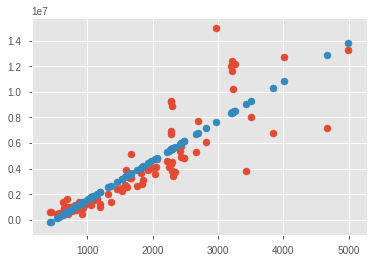

In [50]:
# plot actual vs predicted
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.scatter(X, y)
plt.scatter(X, y_pred);

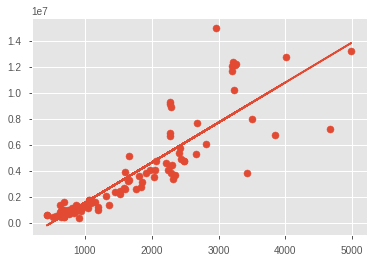

In [51]:
# Interpolate
plt.scatter(X, y)
plt.plot(X, y_pred);

In [0]:
# What pattern did the model "learn", 
# about the relationship between square feet & price?

In [52]:
model.coef_[0]

3076.4476554190023

In [53]:
model.intercept_

-1505364.0408585514

In [54]:
# Equations for a line
print('y = mx + b')
print(f'y = {model.coef_[0]}*x + {model.intercept_}')
print(f'price = {model.coef_[0]}*square_feet + {model.intercept_}')

y = mx + b
y = 3076.4476554190023*x + -1505364.0408585514
price = 3076.4476554190023*square_feet + -1505364.0408585514


In [55]:
# 5. Apply the model to *new/unknown* data
def predict(square_feet):
    y_pred = model.predict([[square_feet]])
    return y_pred[0]

predict(1497)

3100078.099303695

In [56]:
# Give nicer output
def predict(square_feet):
    y_pred = model.predict([[square_feet]])
    estimate = y_pred[0]
    coefficient = model.coef_[0]
    
    # Format with $ and comma separators. No decimals.
    result = f'${estimate:,.0f} estimated price for {square_feet:,.0f} square foot condo in Tribeca.'
    explanation = f' Each additional square foot is associated with a ${coefficient:,.0f} increase in this model.'
    return result + explanation

predict(1497)

'$3,100,078 estimated price for 1,497 square foot condo in Tribeca. Each additional square foot is associated with a $3,076 increase in this model.'

In [57]:
# What does the model for low square footage?
predict(500)

'$32,860 estimated price for 500 square foot condo in Tribeca. Each additional square foot is associated with a $3,076 increase in this model.'

In [58]:
# For high square footage?
predict(10000)

'$29,259,113 estimated price for 10,000 square foot condo in Tribeca. Each additional square foot is associated with a $3,076 increase in this model.'

In [59]:
# These values are outside the min & max of the data the model was fit on,
# but predictive models assume future data will have similar distribution.
df['SALE_PRICE'].describe()

count           90
mean     3,928,736
std      3,621,996
min        424,770
25%      1,156,552
50%      2,750,000
75%      5,087,500
max     15,000,000
Name: SALE_PRICE, dtype: float64

In [60]:
df['GROSS_SQUARE_FEET'].describe()

count      90
mean    1,766
std     1,019
min       432
25%       874
50%     1,626
75%     2,308
max     4,986
Name: GROSS_SQUARE_FEET, dtype: float64

In [61]:
predict(630)

'$432,798 estimated price for 630 square foot condo in Tribeca. Each additional square foot is associated with a $3,076 increase in this model.'

In [62]:
# Re-run the prediction functon interactively
from ipywidgets import interact
interact(predict, square_feet=(630, 5000)); # (min, max)

interactive(children=(IntSlider(value=2815, description='square_feet', max=5000, min=630), Output()), _dom_cla…

### Organize & comment code

In [63]:
from ipywidgets import interact
import pandas as pd
from sklearn.linear_model import LinearRegression

# Read New York City property sales data, from first 4 months of 2019.
# Dataset has 23040 rows, 21 columns.
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')
assert df.shape == (23040, 21)

# Change column names. Replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# Remove symbols from SALE_PRICE string, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# Keep subset of rows:
# Tribeca neighborhood, Condos - Elevator Apartments, 
# 1 unit, sale price more than $1, less than $35 million
mask = (
    (df['NEIGHBORHOOD'].str.contains('TRIBECA')) & 
    (df['BUILDING_CLASS_CATEGORY'] == '13 CONDOS - ELEVATOR APARTMENTS') &
    (df['TOTAL_UNITS'] == 1) & 
    (df['SALE_PRICE'] > 0) & 
    (df['SALE_PRICE'] < 35000000)
)
df = df[mask]

# Data now has 90 rows, 21 columns
assert df.shape == (90, 21)

# Convert SALE_DATE to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Arrange X features matrix & y target vector
features = ['GROSS_SQUARE_FEET']
target = 'SALE_PRICE'
X = df[features]
y = df[target]

# Fit model
model = LinearRegression()
model.fit(X, y)

# Predict
def predict(square_feet):
    y_pred = model.predict([[square_feet]])
    estimate = y_pred[0]
    coefficient = model.coef_[0]
    
    # Format with $ and comma separators. No decimals.
    result = f'${estimate:,.0f} estimated price for {square_feet:,.0f} square foot condo in Tribeca.'
    explanation = f' Each additional square foot adds about ${coefficient:,.0f}'
    return result + explanation

interact(predict, square_feet=(630, 5000)); # (min, max)

interactive(children=(IntSlider(value=2815, description='square_feet', max=5000, min=630), Output()), _dom_cla…

# How'd we do? ...